In [3]:
import pandas as pd
import sklearn
import numpy as np
from scipy import optimize
from scipy.optimize import brute
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [4]:
inputs = pd.read_csv('../data/processed/inputs.csv')
inputs.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AGE,DAYS_EMPLOYED,FLAG_WORK_PHONE
0,1,1,0,112500.0,58.832877,1134,0
1,0,1,0,270000.0,52.356164,3051,0
2,0,1,0,270000.0,52.356164,3051,0
3,0,1,0,270000.0,52.356164,3051,0
4,0,1,0,270000.0,52.356164,3051,0


In [5]:
inputs.describe()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AGE,DAYS_EMPLOYED,FLAG_WORK_PHONE
count,303930.000000,303930.000000,303930.000000,303930.000000,303930.000000,303930.000000,303930.000000
mean,0.413816,0.682335,0.511006,192896.415849,40.566016,2622.640091,0.248044
std,0.492517,0.465569,0.765483,97418.205611,9.555373,2401.230831,0.431878
min,0.000000,0.000000,0.000000,27000.000000,20.517808,12.000000,0.000000
25%,0.000000,0.000000,0.000000,135000.000000,32.717808,919.000000,0.000000
50%,0.000000,1.000000,0.000000,180000.000000,39.950685,1917.000000,0.000000
75%,1.000000,1.000000,1.000000,225000.000000,47.778082,3509.000000,0.000000
max,1.000000,1.000000,19.000000,990000.000000,67.863014,17531.000000,1.000000


In [6]:
outputs = pd.read_csv('../data/processed/outputs.csv')
outputs.head()

,APPROVED
0,1
1,1
2,0
3,0
4,1


In [7]:
outputs.describe()

,APPROVED
count,303930.000000
mean,0.610838
std,0.487561
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


count    303930.000000
mean     192896.415849
std       97418.205611
min       27000.000000
25%      135000.000000
50%      180000.000000
75%      225000.000000
max      990000.000000
Name: AMT_INCOME_TOTAL, dtype: float64

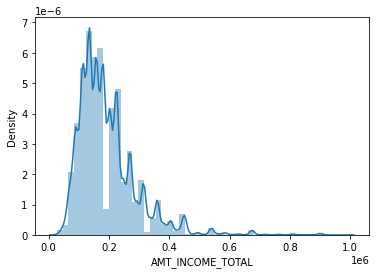

In [8]:
import seaborn as sns

sns.distplot(inputs['AMT_INCOME_TOTAL'])

inputs['AMT_INCOME_TOTAL'].describe()

## Plots

Plots for presentation.

[Text(0.5, 0, 'Age (years)'), Text(0.5, 1.0, 'Age distribution')]

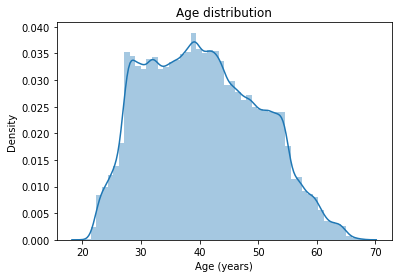

In [9]:
import matplotlib.pyplot as plt

ax = sns.distplot(inputs.AGE)
ax.set(xlabel='Age (years)', title='Age distribution')

[Text(0.5, 0, 'Income (k)'), Text(0.5, 1.0, 'Income distribution')]

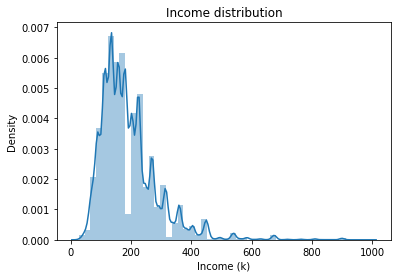

In [9]:
ax = sns.distplot(inputs.AMT_INCOME_TOTAL / 1000.0)
ax.set(xlabel='Income (k)', title='Income distribution')

[Text(0.5, 0, 'Days of employment'),
 Text(0.5, 1.0, 'Days of employment distribution')]

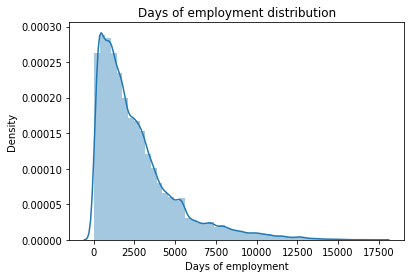

In [10]:
ax = sns.distplot(inputs.DAYS_EMPLOYED[inputs.DAYS_EMPLOYED >= 0])
ax.set(xlabel='Days of employment', title='Days of employment distribution')

<AxesSubplot:xlabel='AGE', ylabel='APPROVED'>

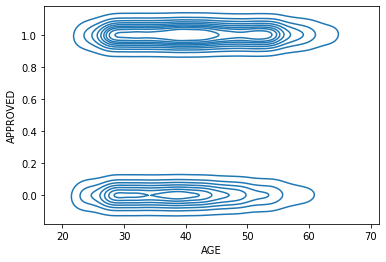

In [11]:
import seaborn as sns

sns.kdeplot(inputs['AGE'], outputs['APPROVED'])

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='APPROVED'>

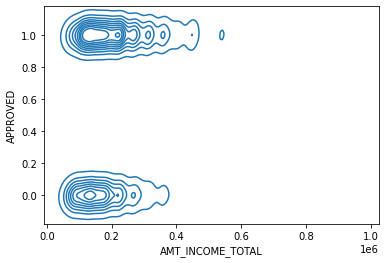

In [12]:
sns.kdeplot(inputs['AMT_INCOME_TOTAL'], outputs['APPROVED'])

In [10]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.4, random_state=23)

In [11]:
X_train

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AGE,DAYS_EMPLOYED,FLAG_WORK_PHONE
53310,1,0,1,225000.0,39.235616,501,0
181032,0,1,0,202500.0,63.145205,6629,0
271924,0,1,0,112500.0,54.602740,2472,0
179174,1,1,0,180000.0,48.295890,537,0
210026,1,0,0,315000.0,51.473973,4301,0
...,...,...,...,...,...,...,...
202783,0,1,0,135000.0,34.887671,644,0
271848,1,1,0,202500.0,29.509589,1685,0
223177,1,1,1,450000.0,37.336986,389,0
271400,1,1,1,342000.0,36.912329,1245,0


In [12]:
y_train

,APPROVED
53310,1
181032,0
271924,1
179174,0
210026,1
...,...
202783,0
271848,0
223177,1
271400,1


Training a random forest with the default hyper-parameters. We will use this as a baseline for the model size optimisation.

In [18]:
rf = RandomForestClassifier(verbose=True, n_jobs=-1)

In [19]:
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline

categorical = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_WORK_PHONE']
numerical = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AGE', 'DAYS_EMPLOYED']

In [21]:
def make_pipeline(classifier):
     return Pipeline([
            ("mapper", DataFrameMapper([
                (categorical, preprocessing.OrdinalEncoder()),
                (numerical, None)
            ])),
            ("classifier", classifier)
        ])

In [22]:
pipeline = make_pipeline(rf)

In [23]:
pipeline.fit(inputs, outputs)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                                             'FLAG_WORK_PHONE'],
                                            OrdinalEncoder()),
                                           (['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                                             'AGE', 'DAYS_EMPLOYED'],
                                            None)])),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, verbose=True))])

In [24]:
pipeline.predict_proba(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


array([[0.68016421, 0.31983579],
       [0.26893723, 0.73106277],
       [0.68328062, 0.31671938],
       ...,
       [0.32045635, 0.67954365],
       [0.55233814, 0.44766186],
       [0.56725564, 0.43274436]])

In [26]:
MSE = pipeline.score(X_test, y_test)*100
print(f"MSE: {MSE}%")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s


MSE: 72.74701411509228%


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished


In [27]:
print(pipeline[1].estimators_[0].tree_.max_depth)

51


In [28]:
depths = [tree.tree_.max_depth for tree in pipeline[1].estimators_]

<AxesSubplot:ylabel='Density'>

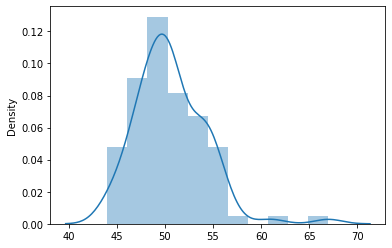

In [29]:
sns.distplot(depths)

In [30]:
from joblib import dump
import os

DEST = "/tmp/model.joblib"
dump(pipeline, DEST)
print(f"Random Forest size: {np.round(os.path.getsize(DEST) / 1024 / 1024, 2) } MB")

Random Forest size: 656.72 MB


## Reducing the size

In [32]:
rf = RandomForestClassifier(verbose=True, max_depth=6, n_jobs=-1)

In [33]:
pipeline = make_pipeline(rf)

In [34]:
pipeline.fit(inputs, outputs)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                                             'FLAG_WORK_PHONE'],
                                            OrdinalEncoder()),
                                           (['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                                             'AGE', 'DAYS_EMPLOYED'],
                                            None)])),
                ('classifier',
                 RandomForestClassifier(max_depth=6, n_jobs=-1, verbose=True))])

In [35]:
MSE_shallow = pipeline.score(X_test, y_test)*100
print(f"MSE (shallow): {MSE_shallow}%, MSE (full): {MSE}%")

MSE (shallow): 65.01168032112658%, MSE (full): 72.74701411509228%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


In [36]:
print(pipeline[1].estimators_[0].tree_.max_depth)

6


In [37]:
depths = [tree.tree_.max_depth for tree in pipeline[1].estimators_]

<AxesSubplot:ylabel='Density'>

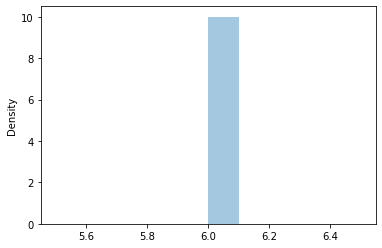

In [38]:
sns.distplot(depths)

In [39]:
DEST = "/tmp/model.joblib"
dump(pipeline, DEST)
print(f"Random Forest size: {np.round(os.path.getsize(DEST) / 1024 / 1024, 2) } MB")

Random Forest size: 0.9 MB
